In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from pmdarima import auto_arima
import warnings
from sklearn.metrics import mean_squared_error
from math import sqrt
import statsmodels.api as sm
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time


In [3]:
TC= pd.read_csv("GlobalLandTemperaturesByCountry.csv", encoding='ISO-8859-1')
TC=TC.dropna()
TC['dt'] = pd.to_datetime(TC['dt'])
unique_count = TC['Country'].nunique()
print(unique_count)
TC_6013=TC.drop(TC[TC['dt'] < "1960-01-01" ].index)
TC_6013.set_index("dt", inplace=True)
TUN_TC= TC_6013[TC_6013["Country"]=="Tunisia"]
print(TUN_TC.head())
print(TUN_TC.info)

242
            AverageTemperature  AverageTemperatureUncertainty  Country
dt                                                                    
1960-01-01              10.787                          0.579  Tunisia
1960-02-01              14.914                          0.912  Tunisia
1960-03-01              16.294                          0.163  Tunisia
1960-04-01              17.377                          0.788  Tunisia
1960-05-01              23.370                          0.651  Tunisia
<bound method DataFrame.info of             AverageTemperature  AverageTemperatureUncertainty  Country
dt                                                                    
1960-01-01              10.787                          0.579  Tunisia
1960-02-01              14.914                          0.912  Tunisia
1960-03-01              16.294                          0.163  Tunisia
1960-04-01              17.377                          0.788  Tunisia
1960-05-01              23.370           

C:\Users\AHMED\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


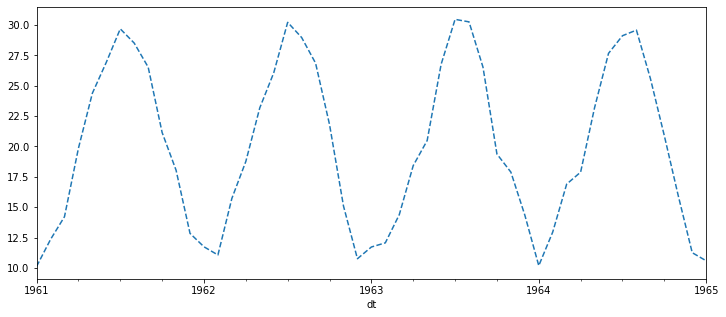

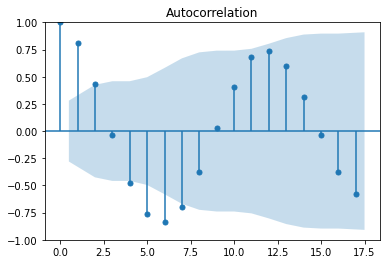

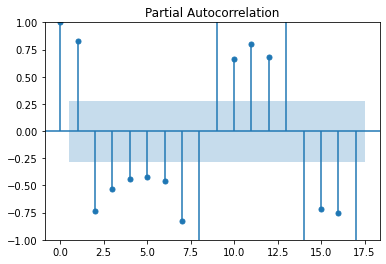

In [4]:
#STUDY THE DATA OF TUNISIA
TUN_TC.loc["1961-01-01":"1965-01-01"]["AverageTemperature"].plot(figsize=(12,5),linestyle='--')
acf_plot = plot_acf(TUN_TC.loc["1961-01-01":"1965-01-01"]["AverageTemperature"])
pacf_plot = plot_pacf(TUN_TC.loc["1961-01-01":"1965-01-01"]["AverageTemperature"])



In [5]:
model = auto_arima(TUN_TC["AverageTemperature"], seasonal=True, m=12)

# Get the order parameters of the best model
order = model.order
seasonal_order = model.seasonal_order
train=TUN_TC.iloc[:-30]
test=TUN_TC.iloc[-30:]


C:\Users\AHMED\AppData\Local\Temp\ipykernel_12464\3044126147.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Country'] = train['Country'].astype(str)
C:\Users\AHMED\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\AHMED\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\AHMED\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.


object
0
(1, 0, 0)
(2, 0, 1, 12)
dt
2011-03-01    15.940881
2011-04-01    19.383763
2011-05-01    24.203134
2011-06-01    28.496304
2011-07-01    31.381043
2011-08-01    31.124361
2011-09-01    27.162393
2011-10-01    22.580020
2011-11-01    16.642914
2011-12-01    12.465457
2012-01-01    11.608165
2012-02-01    13.051777
2012-03-01    16.339973
2012-04-01    19.526951
2012-05-01    24.130030
2012-06-01    28.481300
2012-07-01    31.375771
2012-08-01    31.110084
2012-09-01    27.117455
2012-10-01    22.495947
2012-11-01    16.675939
2012-12-01    12.562149
2013-01-01    11.662039
2013-02-01    12.921217
2013-03-01    16.289289
2013-04-01    19.506358
2013-05-01    24.134534
2013-06-01    28.478077
2013-07-01    31.370873
2013-08-01    31.106311
Name: SARIMA Predictions, dtype: float64
1.1433251072192427
<bound method DataFrame.info of             AverageTemperature  AverageTemperatureUncertainty  Country
dt                                                                    
1960-01-01

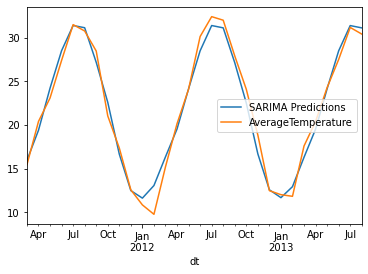

In [6]:
train['Country'] = train['Country'].astype(str)
print(train['Country'].dtype)
print(train['Country'].isnull().sum())
print(order)
print(seasonal_order)
model = SARIMAX(train["AverageTemperature"], order=order, seasonal_order=seasonal_order)
model_fit = model.fit()
model_fit.summary()
start=len(train)
end=len(train)+len(test)-1
pred=model_fit.predict(start=start,end=end,typ='levels').rename('SARIMA Predictions')
pred.index=TUN_TC.index[start:end+1]
print(pred)
pred.plot(legend=True)
test['AverageTemperature'].plot(legend=True)
test['AverageTemperature'].mean()
rmse=sqrt(mean_squared_error(pred,test['AverageTemperature']))
print(rmse)
print(TUN_TC.info)


In [8]:
#TO PREDICT FUTURE VALUES
model2=SARIMAX(TUN_TC['AverageTemperature'],order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
model2=model2.fit()
TUN_TC.tail()
index_future_dates=pd.date_range(start='2013-09-01',end='2030-12-01',freq=pd.DateOffset(months=1))
print(index_future_dates)
pred2=model2.predict(start=len(TUN_TC),end=len(TUN_TC)+len(index_future_dates)- 1,typ='levels').rename('AverageTemperature')
pred2.index=index_future_dates
pred2 = pred2.to_frame()
#print(pred2)
#plt.plot(pred2.index, pred2.values, label='ARIMA Predictions')
pred2["AverageTemperatureUncertainty"]=[rmse for _ in range(len(pred2))]
pred2["Country"]=["Tunisia" for _ in range(len(pred2))]
TC_6013 = pd.concat([TC_6013, pred2])
print(pred2)
print(TC_6013[TC_6013["Country"]=="Tunisia"])
pred3.to_csv('pred3.csv', index=True)

C:\Users\AHMED\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\AHMED\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


DatetimeIndex(['2013-09-01', '2013-10-01', '2013-11-01', '2013-12-01',
               '2014-01-01', '2014-02-01', '2014-03-01', '2014-04-01',
               '2014-05-01', '2014-06-01',
               ...
               '2030-03-01', '2030-04-01', '2030-05-01', '2030-06-01',
               '2030-07-01', '2030-08-01', '2030-09-01', '2030-10-01',
               '2030-11-01', '2030-12-01'],
              dtype='datetime64[ns]', length=208, freq='<DateOffset: months=1>')
            AverageTemperature  AverageTemperatureUncertainty  Country
2013-09-01           27.644955                       1.143325  Tunisia
2013-10-01           22.708207                       1.143325  Tunisia
2013-11-01           16.977114                       1.143325  Tunisia
2013-12-01           12.472667                       1.143325  Tunisia
2014-01-01           11.498339                       1.143325  Tunisia
...                        ...                            ...      ...
2030-08-01           32.337244  

NameError: name 'pred3' is not defined